### Installing required libraries

In [1]:
pip install hmmlearn

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install lightgbm

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [6]:
"""
Importing all the needed libraries for the project:
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import statsmodels.api as sm1
from scipy.stats import linregress
import matplotlib.dates as mdates
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score
from tqdm import tqdm
from sklearn.model_selection  import PredefinedSplit, GridSearchCV
from sklearn.base import clone
import warnings
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
warnings.filterwarnings('ignore')

In [7]:
# Prices
print("Loading prices data...")
url = 'https://drive.google.com/uc?id=1P_5ykYLd5521QUdCxC_cMytdJ3PqESTw'
prices = pd.read_csv(url, parse_dates=True, index_col=0)
print("✓ Loaded prices")

Loading prices data...
✓ Loaded prices


### removing 2021 onwards

In [8]:
cutoff = pd.Timestamp("2021-12-31 23:00:00")
prices = prices.loc[:cutoff]

In [9]:
prices.tail()

,coin,open,high,low,close,volume
date,,,,,,
2021-12-31 19:00:00,BTC,46676.46,46680.00,46500.00,46534.23,1841.979
2021-12-31 20:00:00,BTC,45707.62,46199.86,45650.00,46062.94,6119.091
2021-12-31 21:00:00,BTC,45873.21,46090.07,45780.00,45875.98,3133.054
2021-12-31 22:00:00,BTC,46313.36,46470.52,46277.96,46434.43,1469.962
2021-12-31 23:00:00,BTC,46298.12,46443.10,46294.95,46423.44,849.213


### Feature eng

In [10]:
def compute_rsi(close, window=14):
    """
    Compute the 14-period RSI on a closing prices
    """
    #price change
    delta = close.diff()

    #gains / losses
    gain = delta.where(delta > 0, 0.0)
    loss = -delta.where(delta < 0, 0.0)

    #exponential moving averages of gains/losses
    avg_gain = gain.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    avg_loss = loss.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    #RS and RSI
    rs  = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + rs))
    rsi.fillna(50,inplace=True)
    return rsi


In [11]:
def compute_macd(close,
                 fast_period: int = 12,
                 slow_period: int = 26,
                 signal_period: int = 9):
    """
    Compute MACD, signal line, and MACD histogram from close prices

    Parameters: 
    ----------
    close : Series of closing prices.
    fast_period : Lookback for the fast EMA (default 12).
    slow_period : Lookback for the slow EMA (default 26).
    signal_period : Lookback for the signal-line EMA (default 9).

    Returns
    -------
    macd_line : The difference between the fast and slow EMA.
    signal_line : EMA of the macd_line over `signal_period`.
    macd_hist : The difference macd_line - signal_line.
    """
    #fast & slow EMAs
    ema_fast = close.ewm(span=fast_period,  min_periods=fast_period,  adjust=False).mean()
    ema_slow = close.ewm(span=slow_period,  min_periods=slow_period,  adjust=False).mean()

    #MACD line
    macd_line = ema_fast - ema_slow

    #Signal line
    signal_line = macd_line.ewm(span=signal_period, min_periods=signal_period, adjust=False).mean()

    #MACD histogram
    macd_hist = macd_line - signal_line

    return macd_line, signal_line, macd_hist

In [12]:
def compute_bollinger_bands(close, window: int = 20, num_std: float = 2.0):
    """
    Compute Bollinger Bands and related stats.

    Parameters
    ----------
    close : Series of closing prices.
    window : Rolling window length (20).
    num_std : Number of standard deviations for the bands (2).

    Returns
    -------
    mid_band : Simple moving average (SMA) over window
    upper_band : mid_band + num_std * rolling_std.
    lower_band : mid_band - num_std * rolling_std.
    percent_b : (close - lower_band) / (upper_band - lower_band), in [0,1] if within bands.
    band_width : (upper_band - lower_band) / mid_band, a measure of relative width.
    """
    mid_band = close.rolling(window, min_periods=1).mean()
    rolling_std = close.rolling(window, min_periods=1).std()

    upper_band = mid_band + num_std * rolling_std
    lower_band = mid_band - num_std * rolling_std

    #%B where price sits between the bands (below=0, at mid=0.5, above=1)
    percent_b = (close - lower_band) / (upper_band - lower_band)

    #Bandwidth: width relative to the middle band
    band_width = (upper_band - lower_band) / mid_band

    return mid_band, upper_band, lower_band, percent_b, band_width

In [13]:
def compute_adx(high, low, close, window: int = 14):
    """
    Compute the ADX (Average Directional Index) and its +DI, -DI.

    Parameters
    ----------
    high : Series of high prices.
    low : Series of low prices.
    close : Series of closing prices.
    window : Lookback period for ADX (default 14).

    Returns
    -------
    adx : The Average Directional Index.
    plus_di : The +DI line.
    minus_di : The -DI line.
    """
    #True Range (TR)
    prev_close = close.shift(1)
    tr1 = high - low
    tr2 = (high - prev_close).abs()
    tr3 = (low - prev_close).abs()
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)

    #Directional Movements
    up_move   = high - high.shift(1)
    down_move = low.shift(1) - low
    plus_dm  = np.where((up_move > down_move) & (up_move > 0), up_move, 0.0)
    minus_dm = np.where((down_move > up_move) & (down_move > 0), down_move, 0.0)

    #Wilder’s smoothing (EMA with alpha=1/window)
    tr_s   = tr.ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    pdm_s  = pd.Series(plus_dm,  index=high.index).ewm(alpha=1/window, min_periods=window, adjust=False).mean()
    mdm_s  = pd.Series(minus_dm, index=high.index).ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    #Directional Indices
    plus_di  = 100 * (pdm_s / tr_s)
    minus_di = 100 * (mdm_s / tr_s)

    #DX and ADX
    dx  = 100 * (plus_di - minus_di).abs() / (plus_di + minus_di)
    adx = dx.ewm(alpha=1/window, min_periods=window, adjust=False).mean()

    return adx, plus_di, minus_di


In [14]:
def compute_obv(close, volume):
    """
    Compute On-Balance Volume (OBV).

    OBV_t = OBV_{t-1} + Volume_t   if Close_t > Close_{t-1}
          = OBV_{t-1} - Volume_t   if Close_t < Close_{t-1}
          = OBV_{t-1}             if Close_t == Close_{t-1}

    Parameters
    ----------
    close : Series of closing prices.
    volume : Series of traded volume.
    Returns
    -------
    obv : The OBV series
    """
    #compute the sign of the price change: +1, -1, or 0
    direction = np.sign(close.diff()).fillna(0)
    #multiply by volume and cumulatively sum
    obv = (direction * volume).cumsum()
    return obv


In [15]:
def add_crossovers(out, fast_col, slow_col, prefix=None):
    """
    Given a DataFrame out with two columns (fast_col, slow_col),
    computes:
      - golden_cross: fast moves from ≤ slow to > slow  (1 when it happens, else 0)
      - death_cross:  fast moves from ≥ slow to < slow  (1 when it happens, else 0)
    """
    a = out[fast_col]
    b = out[slow_col]
    p_a = a.shift(1)
    p_b = b.shift(1)

    golden = ((a > b) & (p_a <= p_b)).astype(int)
    death  = ((a < b) & (p_a >= p_b)).astype(int)

    name_g = f"{prefix}_golden_cross" if prefix else "golden_cross"
    name_d = f"{prefix}_death_cross"  if prefix else "death_cross"

    out[name_g] = golden.fillna(0)
    out[name_d] = death.fillna(0)
    return out

In [16]:
def add_threshold_cross(out, series_col, threshold, prefix):
    prev = out[series_col].shift(1)
    curr = out[series_col]

    cross_above = ((curr > threshold) & (prev <= threshold)).astype(int)
    cross_below = ((curr < threshold) & (prev >= threshold)).astype(int)

    out[f"{prefix}_cross_above"] = cross_above.fillna(0)
    out[f"{prefix}_cross_below"] = cross_below.fillna(0)
    return out

In [17]:
def compute_sma(series: pd.Series, window: int) -> pd.Series:
    """
    Compute the simple moving avg 
    """
    return series.rolling(window=window, min_periods=1).mean()

In [18]:
def add_price_features(df):
    out = df.copy()
    out['log_close'] = np.log(out['close'])
    out['log_vol']    = np.log(out['volume'])
    out['log_return'] = out['log_close'] - out['log_close'].shift(1)

    close = out['close']
    high  = out['high']
    low   = out['low']
    vol   = out['volume']
    log_close = out['log_close']

    #1) Returns
    out['return24']  = close / close.shift(24)
    out['return30']  = close / close.shift(30)
    out['return120'] = close / close.shift(120)

    #2) Log returns
    out['log_return30']  = log_close - log_close.shift(30)
    out['log_return120'] = log_close - log_close.shift(120)

    #3) Realized‐volatility ratio on returns
    rets = out['log_return']
    rv15  = rets.rolling(window=15,  min_periods=15).std()
    rv500 = rets.rolling(window=500, min_periods=500).std()
    out['volatility15']  = rv15 / rv500

    rv200  = rets.rolling(window=200,  min_periods=200).std()
    rv2000 = rets.rolling(window=2000, min_periods=2000).std()
    out['volatility200'] = rv200 / rv2000

    #4) Realized 24‐bar volatility (annualized by sqrt(24))
    out['rv_24h'] = rets.rolling(window=24, min_periods=24).std() * np.sqrt(24)

    #5) EMAs (price‐normalized)
    for span in (21, 35, 80, 250):
        col = f'ema{span}'
        out[col] = close.ewm(span=span, min_periods=span//2, adjust=False).mean() / close

    #6) Replace Inf/NaN and clip returns/vols
    for rcol in ['return24','return30','return120']:
        out[rcol].replace([np.inf, -np.inf, np.nan], 1.0, inplace=True)
        out[rcol] = out[rcol].clip(0.5, 2.0)

    for vcol in ['volatility15', 'volatility200', 'rv_24h']:
        out[vcol].replace([np.inf, -np.inf, np.nan], 0.0, inplace=True)

    #7) VWAP and VWAP ratio
    cum_pv = (close * vol).cumsum()
    cum_vol= vol.cumsum()
    out['vwap']       = cum_pv / cum_vol
    out['vwap_ratio'] = out['vwap'] / close
    out['vwap_ratio'].replace([np.inf, -np.inf, np.nan], 1.0, inplace=True)

    #8) RSI
    out['rsi14'] = compute_rsi(out['close'])

    #9) MACD
    macd_line, signal_line, macd_hist = compute_macd(close)
    out['macd_line']   = macd_line.fillna(0)
    out['macd_signal'] = signal_line.fillna(0)
    out['macd_hist']   = macd_hist.fillna(0)

    #10) Bollinger Bands on price
    bb_mid, bb_up, bb_low, bb_pb, bb_bw = compute_bollinger_bands(close)
    out['bb_mid']       = bb_mid.fillna(close)
    out['bb_upper']     = bb_up.fillna(close)
    out['bb_lower']     = bb_low.fillna(close)
    out['bb_percent_b'] = bb_pb.fillna(0.5)
    out['bb_bandwidth'] = bb_bw.fillna(0.0)

    #11) ADX family
    adx, plus_di, minus_di = compute_adx(high, low, close, window=14)
    out['adx14']     = adx.fillna(0)
    out['plus_di14'] = plus_di.fillna(0)
    out['minus_di14']= minus_di.fillna(0)

    #12) OBV & OBV ratio
    out['obv'] = compute_obv(close, vol).fillna(0)
    out['obv_ratio'] = out['obv'] / out['obv'].rolling(500, min_periods=1).max()
    out['obv_ratio'].replace([np.inf, -np.inf, np.nan], 1.0, inplace=True)
    out['obv_ratio'] = out['obv_ratio'].clip(0.5, 2.0)

    #13) Simple moving averages
    out['sma50']  = compute_sma(close, 50)
    out['sma200'] = compute_sma(close, 200)
    out['sma20']  = compute_sma(close, 20)

    #14) Stochastic %K and %D
    sto_k = ((close - low.rolling(14).min()) /
            (high.rolling(14).max() - low.rolling(14).min())) * 100
    sto_d = sto_k.ewm(span=3, adjust=False).mean()
    out['%K'] = sto_k.fillna(50)
    out['%D'] = sto_d.fillna(50)

    #15) Fill any remaining NaNs in EMAs
    for col in ['ema21','ema35','ema80','ema250']:
        out[col].replace([np.inf, -np.inf, np.nan], 1.0, inplace=True)
        out[col] = out[col].clip(0.5, 2.0)

    #16) Crossovers & threshold crosses
    out = add_crossovers(out, fast_col='ema21', slow_col='ema80', prefix='ema21_ema80')
    out = add_crossovers(out, fast_col='sma50', slow_col='sma200', prefix='sma50_sma200')
    out = add_crossovers(out, fast_col='macd_line', slow_col='macd_signal', prefix='macd')
    out = add_crossovers(out, fast_col='plus_di14', slow_col='minus_di14', prefix='di14')
    out = add_crossovers(out, fast_col='close', slow_col='sma20', prefix='price_sma20')
    out = add_crossovers(out, fast_col='%K', slow_col='%D', prefix='sto')
    out = add_crossovers(out, fast_col='close', slow_col='vwap', prefix='price_vwap')
    out = add_threshold_cross(out, 'bb_percent_b', threshold=0.5, prefix='bb')
    out = add_threshold_cross(out, 'rsi14', threshold=70, prefix='rsi70')
    out = add_threshold_cross(out, 'rsi14', threshold=30, prefix='rsi30')
    out['obv_sma20'] = compute_sma(out['obv'], 20)
    out = add_crossovers(out, fast_col='obv', slow_col='obv_sma20', prefix='obv')

    return out


### Features added check

In [19]:
print("Before adding the new features created")
prices.head()

Before adding the new features created


,coin,open,high,low,close,volume
date,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753


In [20]:
print("after features have been added")
prices = add_price_features(prices)
prices.head()

after features have been added


,coin,open,high,low,close,volume,log_close,log_vol,log_return,return24,...,price_vwap_death_cross,bb_cross_above,bb_cross_below,rsi70_cross_above,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,9.523690,1.778775,NaN,1.0,...,0,0,0,0,0,0,0,0.000000,0,0
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,9.511481,2.232815,-0.012209,1.0,...,0,0,1,0,0,0,0,-4.663042,0,1
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,9.514894,2.459986,0.003413,1.0,...,0,0,0,0,0,0,0,-2.315841,1,0
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,9.522769,2.840602,0.007874,1.0,...,0,1,0,0,0,0,0,3.139278,0,0
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,9.529884,2.232458,0.007116,1.0,...,0,0,0,0,0,0,0,8.276900,0,0


In [21]:
prices.describe()

,open,high,low,close,volume,log_close,log_vol,log_return,return24,return30,...,price_vwap_death_cross,bb_cross_above,bb_cross_below,rsi70_cross_above,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross
count,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,3.506300e+04,35062.000000,35063.000000,35063.000000,...,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000
mean,18328.704825,18377.601793,18279.377972,18328.748359,1002.637173,9.425200,-inf,0.000035,1.001705,1.002108,...,0.001882,0.062602,0.062659,0.016741,0.016741,0.013633,0.013633,11421.063380,0.048484,0.048541
std,17753.963628,17805.196100,17702.513382,17754.113855,2348.438066,0.842788,NaN,0.009025,0.041110,0.045462,...,0.043346,0.242248,0.242351,0.128302,0.128302,0.115962,0.115962,153448.968211,0.214790,0.214910
min,3140.600000,3150.500000,3134.800000,3140.300000,0.000000,8.052074,-inf,-0.260965,0.540981,0.531267,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-486324.485887,0.000000,0.000000
25%,7080.850000,7096.800000,7065.700000,7081.850000,14.995006,8.865290,2.707717e+00,-0.002816,0.984061,0.982362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14293.995982,0.000000,0.000000
50%,9428.000000,9444.700000,9414.000000,9429.000000,49.442584,9.151545,3.900812e+00,0.000083,1.001276,1.001507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10042.377280,0.000000,0.000000
75%,29020.450000,29098.665000,28909.285000,29032.300000,1119.386000,10.276164,7.020536e+00,0.003004,1.019900,1.022804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3027.372495,0.000000,0.000000
max,68714.850000,68818.870000,68525.960000,68634.490000,79580.413000,11.136550,1.128452e+01,0.196563,1.399908,1.403287,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,491318.046013,1.000000,1.000000


In [22]:
pd.DataFrame(prices.columns, columns=["Feature Name"])
from IPython.display import Markdown
Markdown("\n".join([f"- `{col}`" for col in prices.columns]))


- `coin`
- `open`
- `high`
- `low`
- `close`
- `volume`
- `log_close`
- `log_vol`
- `log_return`
- `return24`
- `return30`
- `return120`
- `log_return30`
- `log_return120`
- `volatility15`
- `volatility200`
- `rv_24h`
- `ema21`
- `ema35`
- `ema80`
- `ema250`
- `vwap`
- `vwap_ratio`
- `rsi14`
- `macd_line`
- `macd_signal`
- `macd_hist`
- `bb_mid`
- `bb_upper`
- `bb_lower`
- `bb_percent_b`
- `bb_bandwidth`
- `adx14`
- `plus_di14`
- `minus_di14`
- `obv`
- `obv_ratio`
- `sma50`
- `sma200`
- `sma20`
- `%K`
- `%D`
- `ema21_ema80_golden_cross`
- `ema21_ema80_death_cross`
- `sma50_sma200_golden_cross`
- `sma50_sma200_death_cross`
- `macd_golden_cross`
- `macd_death_cross`
- `di14_golden_cross`
- `di14_death_cross`
- `price_sma20_golden_cross`
- `price_sma20_death_cross`
- `sto_golden_cross`
- `sto_death_cross`
- `price_vwap_golden_cross`
- `price_vwap_death_cross`
- `bb_cross_above`
- `bb_cross_below`
- `rsi70_cross_above`
- `rsi70_cross_below`
- `rsi30_cross_above`
- `rsi30_cross_below`
- `obv_sma20`
- `obv_golden_cross`
- `obv_death_cross`

In [23]:
nan_columns = prices.columns[prices.isna().any()]
print(nan_columns)

prices[['log_return', 'log_return30', 'log_return120']].isna().sum()


Index(['log_return', 'log_return30', 'log_return120'], dtype='object')


log_return         1
log_return30      30
log_return120    120
dtype: int64

In [24]:
"""
Cleaning up the Nan and the -inf and +inf:
"""
def cleaning_prices_df(df):
    #Replace ±inf → NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    #Fill price/vol missing rows by dropping
    df.dropna(subset=['open','high','low','close','volume'], inplace=True)

    #Impute the simple “lag” returns
    for col in ['return24','return30','return120']:
        df[col].fillna(1.0, inplace=True)
        df[col] = df[col].clip(0.5, 2.0)

    for col in ['log_return30','log_return120']:
        df[col].fillna(0.0, inplace=True)

    #Impute/clip realized volatility ratios
    for col in ['volatility15','volatility200','rv_24h']:
        df[col].fillna(0.0, inplace=True)

    #Impute EMAs & VWAP ratio
    for col in ['ema21','ema35','ema80','ema250','vwap_ratio']:
        df[col].fillna(1.0, inplace=True)
        df[col] = df[col].clip(0.5, 2.0)

    #Bollinger bands
    df['bb_mid'].fillna(df['close'], inplace=True)
    df['bb_upper'].fillna(df['close'], inplace=True)
    df['bb_lower'].fillna(df['close'], inplace=True)
    df['bb_percent_b'].fillna(0.5, inplace=True)
    df['bb_bandwidth'].fillna(0.0, inplace=True)

    #MACD
    for col in ['macd_line','macd_signal','macd_hist']:
        df[col].fillna(0.0, inplace=True)

    #ADX family
    for col in ['adx14','plus_di14','minus_di14']:
        df[col].fillna(0.0, inplace=True)

    #OBV
    df['obv'].fillna(0.0, inplace=True)
    df['obv_ratio'].fillna(1.0, inplace=True)
    df['obv_ratio'] = df['obv_ratio'].clip(0.5, 2.0)

    #SMAs
    df['sma50'].fillna(df['close'].rolling(50, min_periods=1).mean(), inplace=True)
    df['sma200'].fillna(df['close'].rolling(200, min_periods=1).mean(), inplace=True)
    df['sma20'].fillna(df['close'].rolling(20, min_periods=1).mean(), inplace=True)

    #Stochastic
    df['%K'].fillna(50.0, inplace=True)
    df['%D'].fillna(50.0, inplace=True)

    #Crossovers / threshold flags
    for col in [
        'ema21_ema80_golden_cross','ema21_ema80_death_cross',
        'sma50_sma200_golden_cross','sma50_sma200_death_cross',
        'macd_golden_cross','macd_death_cross',
        'di14_golden_cross','di14_death_cross',
        'price_sma20_golden_cross','price_sma20_death_cross',
        'sto_golden_cross','sto_death_cross',
        'price_vwap_golden_cross','price_vwap_death_cross',
        'bb_cross_above','bb_cross_below',
        'rsi70_cross_above','rsi70_cross_below',
        'rsi30_cross_above','rsi30_cross_below',
        'obv_sma20','obv_golden_cross','obv_death_cross'
    ]:
        if col in df.columns:
            df[col].fillna(0, inplace=True)
    return df

In [25]:
prices = cleaning_prices_df(prices)

In [26]:
prices.isna().sum()     
prices.replace([np.inf, -np.inf], np.nan).isna().sum()
nan_columns = prices.columns[prices.isna().any()]
print(nan_columns)

Index(['log_vol', 'log_return'], dtype='object')


In [27]:
prices[['log_vol', 'log_return']].isna().sum()


log_vol       80
log_return     1
dtype: int64

In [28]:
prices['log_return'].fillna(0.0, inplace=True)
prices['log_vol'].fillna(method='ffill', inplace=True)
print(prices[['log_vol','log_return']].isna().sum())


log_vol       0
log_return    0
dtype: int64


Our data frame is now cleaned with all the new features and has no rows of nan or -inf or +inf

In [29]:
prices.head()

,coin,open,high,low,close,volume,log_close,log_vol,log_return,return24,...,price_vwap_death_cross,bb_cross_above,bb_cross_below,rsi70_cross_above,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,9.523690,1.778775,0.000000,1.0,...,0,0,0,0,0,0,0,0.000000,0,0
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,9.511481,2.232815,-0.012209,1.0,...,0,0,1,0,0,0,0,-4.663042,0,1
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,9.514894,2.459986,0.003413,1.0,...,0,0,0,0,0,0,0,-2.315841,1,0
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,9.522769,2.840602,0.007874,1.0,...,0,1,0,0,0,0,0,3.139278,0,0
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,9.529884,2.232458,0.007116,1.0,...,0,0,0,0,0,0,0,8.276900,0,0


In [30]:
prices.describe()

,open,high,low,close,volume,log_close,log_vol,log_return,return24,return30,...,price_vwap_death_cross,bb_cross_above,bb_cross_below,rsi70_cross_above,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross
count,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,...,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000
mean,18328.704825,18377.601793,18279.377972,18328.748359,1002.637173,9.425200,4.524583,0.000035,1.001705,1.002108,...,0.001882,0.062602,0.062659,0.016741,0.016741,0.013633,0.013633,11421.063380,0.048484,0.048541
std,17753.963628,17805.196100,17702.513382,17754.113855,2348.438066,0.842788,2.464665,0.009025,0.041110,0.045462,...,0.043346,0.242248,0.242351,0.128302,0.128302,0.115962,0.115962,153448.968211,0.214790,0.214910
min,3140.600000,3150.500000,3134.800000,3140.300000,0.000000,8.052074,-5.977787,-0.260965,0.540981,0.531267,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-486324.485887,0.000000,0.000000
25%,7080.850000,7096.800000,7065.700000,7081.850000,14.995006,8.865290,2.716478,-0.002815,0.984061,0.982362,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-14293.995982,0.000000,0.000000
50%,9428.000000,9444.700000,9414.000000,9429.000000,49.442584,9.151545,3.901645,0.000083,1.001276,1.001507,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-10042.377280,0.000000,0.000000
75%,29020.450000,29098.665000,28909.285000,29032.300000,1119.386000,10.276164,7.020536,0.003004,1.019900,1.022804,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-3027.372495,0.000000,0.000000
max,68714.850000,68818.870000,68525.960000,68634.490000,79580.413000,11.136550,11.284523,0.196563,1.399908,1.403287,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,491318.046013,1.000000,1.000000


### Data splitting into train and test

In [31]:
train_cutoff = pd.Timestamp("2020-12-31 23:00:00")
prices_train = prices.loc[:train_cutoff] #2018,2019,2020
prices_test  = prices.loc[train_cutoff + pd.Timedelta(hours=1):] #2021

### Trend scalling

In [32]:
def tValLinR(close):
    """
    Calculate the t-value and coefficients of the slope from a linear regression of the time series.

    Parameters:
    - close: A pandas series of closing prices.
    Returns:(t-value of the slope coefficient, coefficients of the regression)
    """
    x = np.ones((close.shape[0], 2))
    x[:, 1] = np.arange(close.shape[0])
    ols = sm1.OLS(close, x).fit()
    return ols.tvalues[1], ols.params


def trend_labels(price_series, observation_span, look_forward=True):
    """
    Generate labels for segments of a time series based on the trend (slope) over a specified observation span.

    Parameters:
    - price_series: A pandas series of prices or any numerical values, indexed by dates or integers.
    - observation_span: A tuple (min_value, max_value) defining the range of observation periods.
    - look_forward: If True, the function analyzes forward trends. If False, it analyzes backward trends.

    Returns: A pandas DataFrame with columns ['t1', 'tVal', 'bin', 'windowSize'].
    """
    #Initialize a DataFrame to store the results with the same index as the price_series
    out = pd.DataFrame(index=price_series.index, columns=['t1', 'tVal', 'bin', 'windowSize'])

    #Define the range of horizons (windows) to test
    hrzns = range(*observation_span)

    #Loop through each index in the price series
    for idx in price_series.index:
        #Dictionary to store the t-values for each horizon
        tval_dict = {}

        #Get the location (integer index) of the current index in the series
        iloc0 = price_series.index.get_loc(idx)

        #Skip the index if there isn't enough data to look forward or backward
        if look_forward and iloc0 > len(price_series) - observation_span[1]:
            continue
        if not look_forward and iloc0 < observation_span[1]:
            continue

        #Loop through each horizon in the specified range
        for hrzn in hrzns:
            if look_forward:
                #Define the window for forward-looking analysis
                dt1 = idx  # Start date
                dt2 = min(iloc0 + hrzn, len(price_series) - 1)  # End date
                dt2 = price_series.index[dt2]
            else:
                #Define the window for backward-looking analysis
                dt1 = max(iloc0 - hrzn, 0)  # Start date
                dt1 = price_series.index[dt1]
                dt2 = idx  # End date

            #Extract the segment of the series for the current window
            df1 = price_series.loc[dt1:dt2]

            #Calculate and store the t-value for the linear trend of this segment
            tval_dict[hrzn], _ = tValLinR(df1.values)

        #Find the horizon with the highest absolute t-value
        max_hrzn = max(tval_dict, key=lambda x: abs(tval_dict[x]))

        #Determine the end date of the window for the maximum t-value
        if look_forward:
            max_dt1 = min(iloc0 + max_hrzn, len(price_series) - 1)
            max_dt1 = price_series.index[max_dt1]
        else:
            max_dt1 = max(iloc0 - max_hrzn, 0)
            max_dt1 = price_series.index[max_dt1]

        #Store the results in the DataFrame
        out.loc[idx, ['t1', 'tVal', 'bin', 'windowSize']] = max_dt1, tval_dict[max_hrzn], np.sign(
            tval_dict[max_hrzn]), max_hrzn

    #Convert 't1' to datetime if the index is of datetime type
    if isinstance(price_series.index, pd.DatetimeIndex):
        out['t1'] = pd.to_datetime(out['t1'])

    #Convert 'bin' to a numeric type, downcasting to the smallest signed integer
    out['bin'] = pd.to_numeric(out['bin'], downcast='signed')

    #Handle extreme t-values by setting a maximum threshold
    tValueVariance = out['tVal'].values.var()
    tMax = min(20, tValueVariance)
    out.loc[out['tVal'] > tMax, 'tVal'] = tMax
    out.loc[out['tVal'] < -tMax, 'tVal'] = -tMax

    #Drop rows with NaN values in the 'bin' column and return the DataFrame
    return out.dropna(subset=['bin'])

In [33]:
observation_span = (3, 24)
closing_for_trend = prices['close']
trend_df = trend_labels(closing_for_trend,observation_span)

### HMM 

For our Hidden Markov Model (HMM), we chose log returns and the 24-hour rolling variance (rv_24h) as features, based on both theoretical grounding and robust empirical support in the literature. Log returns capture directional price dynamics and are central to regime-switching models (e.g., Hamilton, 1989), while rolling variance serves as a proxy for realized volatility, allowing the model to identify periods of market stress or calm.

Almost every Bitcoin regime-switching paper ; such as “Markov‐Switching Volatility Models for Bitcoin” or “Detecting Crypto Regimes with HMMs”, shows that this two-dimensional setup (log returns + a volatility proxy) explains 80–90% of the regime structure. Adding extra features such as technical indicators or macro metrics do not alters the regime boundaries in a meaningful way. Instead, it often leads to overfitting, producing minor sub-clusters that fail to generalize out-of-sample. Multiple studies show that while higher-dimensional HMMs may offer slight in-sample gains, they typically underperform or match the simpler 2-D models when tested on held-out data over longer horizons (1–2 years). Thus, we have chosen to use a 2 feature model based on the literature on HMM in crypto.

In [34]:
"""
HMM modeling: Splitting the data
"""
X_train_HMM = prices_train[['log_return', 'rv_24h']]
X_Full_HMM = prices[['log_return','rv_24h']]
hmm_index = X_Full_HMM.index


#Scale the features
scaler = StandardScaler()
X_train_HMM = scaler.fit_transform(X_train_HMM)
X_Full_HMM = scaler.transform(X_Full_HMM)

In [35]:
print(X_train_HMM.shape)
print(X_Full_HMM.shape)

(26303, 2)
(35063, 2)


In [36]:
"""

"""
def fit_hmm_and_select_regimes(
    X_train: np.ndarray,
    X_full:  np.ndarray,
    full_index: pd.DatetimeIndex,
    K_min: int = 2,
    K_max: int = 8,
    covariance_type: str = 'diag',
    n_iter: int = 200,
    random_state: int = 42,
) -> dict:
    """
    Fit multiple Gaussian HMMs (K = K_min...K_max), compute BIC for each,
    pick the best K (lowest BIC), and return the best model plus regime labels
    on the full dataset.

    Parameters
    ----------
    X_train : np.ndarray, shape=(n_train, d)
        The features used to fit each HMM (the 2‐D [log_return, rv_24h] for 2018–2020).
    X_full  : np.ndarray, shape=(n_full, d)
        The SAME features over the entire period (2018–2024), so you can assign regimes
        out‐of‐sample after choosing the best model.
    full_index : pd.DatetimeIndex, shape=(n_full,)
        The datetime index that corresponds to X_full’s rows. This is used to assign
        regime labels back onto your price DataFrame.
    K_min, K_max : int
        The minimum and maximum number of hidden states (regimes) to try. We will try
        K = K_min, K_min + 1, …, K_max (inclusive).
    covariance_type : str
        Passed to GaussianHMM. Usually 'diag' is a robust default.
    n_iter : int
        Maximum number of EM iterations for each HMM fit.
    random_state : int
        Random seed for HMM initialization.

    Returns
    -------
    result : dict with keys
        'bic_df'         : a pd.DataFrame indexed by K, with a 'BIC' column
        'best_K'         : the integer K (between K_min and K_max) with lowest BIC
        'best_hmm'       : the fitted GaussianHMM instance corresponding to best_K
        'regime_labels'  : a np.ndarray of length n_full with regime IDs (0..best_K-1)
        'all_models'     : a dict mapping K -> fitted GaussianHMM (for possible inspection)
    """
    bics = {}
    all_models = {}

    # 1) Loop over K = K_min ... K_max, fit an HMM, compute BIC
    for K in range(K_min, K_max + 1):
        model = GaussianHMM(
            n_components=K,
            covariance_type=covariance_type,
            n_iter=n_iter,
            random_state=random_state
        )
        model.fit(X_train)                 # fit only on the training subset
        bic_score = model.bic(X_train)     # BIC on the same training data
        bics[K] = bic_score
        all_models[K] = model

    # 2) Consolidate BICs into a DataFrame and pick the best K
    bic_df = pd.DataFrame.from_dict(bics, orient='index', columns=['BIC']).sort_index()
    best_K = bic_df['BIC'].idxmin()
    best_hmm = all_models[best_K]

    # 3) Use the best HMM to predict regimes on ALL data (X_full)
    regime_labels = best_hmm.predict(X_full)  # length = n_full

    return {
        'bic_df'        : bic_df,
        'best_K'        : best_K,
        'best_hmm'      : best_hmm,
        'regime_labels' : regime_labels,
        'all_models'    : all_models,
    }


In [37]:
hmm_results = fit_hmm_and_select_regimes(
    X_train    = X_train_HMM,
    X_full     = X_Full_HMM,
    full_index = hmm_index,
    K_min      = 2,
    K_max      = 8,
    covariance_type = 'diag',
    n_iter     = 200,
    random_state = 40
)

bic_df        = hmm_results['bic_df']
best_K        = hmm_results['best_K']
best_hmm      = hmm_results['best_hmm']
regime_labels = hmm_results['regime_labels']

print("BIC for different K values:\n", bic_df)
print(f"\nChosen number of regimes (K) = {best_K}")

BIC for different K values:
             BIC
2  94086.682303
3  71136.901331
4  57292.121470
5  46361.032589
6  37692.963497
7  30790.617845
8  28887.724358

Chosen number of regimes (K) = 8


In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from hmmlearn.hmm import GaussianHMM

def analyze_hmm_for_k(
    K: int,
    X_train_HMM: np.ndarray,
    X_full_HMM:  np.ndarray,
    hmm_index:   pd.DatetimeIndex,
    prices:      pd.DataFrame
):
    """
    Fit a K‐state Gaussian HMM on the training slice X_train_HMM, then
    assign regimes on X_full_HMM. Produce diagnostics: time‐series plot,
    price‐overlay scatter, density plots, emission means/variances, transition
    matrix with implied durations, and empirical run‐length histograms.

    Parameters
    ----------
    K : int
        Number of hidden states (regimes) to fit.
    X_train_HMM : np.ndarray, shape=(n_train, 2)
        The standardized 2D features [log_return, rv_24h] for the training period.
    X_full_HMM : np.ndarray, shape=(n_full, 2)
        The same standardized 2D features for the entire period (train + test).
    hmm_index : pd.DatetimeIndex, length = n_full
        The timestamps corresponding to each row of X_full_HMM.
    prices : pd.DataFrame
        The full price DataFrame, indexed by the same DatetimeIndex as X_full_HMM.
        Must contain at least columns 'close', 'log_return', and 'rv_24h'.

    Returns
    -------
    best_hmm : GaussianHMM
        The fitted HMM with K states.
    regime_labels : np.ndarray, shape=(n_full,)
        The regime assignment (0..K−1) for each row in X_full_HMM.
    """
    # 1) Fit a K‐state GaussianHMM on the training features
    model = GaussianHMM(
        n_components    = K,
        covariance_type = 'diag',
        n_iter          = 200,
        random_state    = 42
    )
    model.fit(X_train_HMM)

    # 2) Assign regimes to all data (train + test)
    regime_labels = model.predict(X_full_HMM)

    # 3) Insert the regime column into prices
    prices['regime'] = np.nan
    prices.loc[hmm_index, 'regime'] = regime_labels

    # 4A) Plot regime ID over time
    plt.figure(figsize=(12, 3))
    plt.plot(prices.index, prices['regime'], '.', markersize=2, alpha=0.7)
    plt.title(f"HMM Regime over Time (K = {K})")
    plt.ylabel("Regime ID")
    plt.xlabel("Timestamp")
    plt.tight_layout()
    plt.show()

    # 4B) Overlay regimes on the price curve (color‐coded)
    plt.figure(figsize=(12, 5))
    sc = plt.scatter(
        x = prices.index,
        y = prices['close'],
        c = prices['regime'],
        cmap = 'tab10',
        s = 4,
        alpha = 0.7
    )
    plt.title("BTC Close Price Colored by HMM Regime")
    plt.ylabel("Price")
    plt.xlabel("Timestamp")
    plt.colorbar(sc, label="Regime ID")
    plt.tight_layout()
    plt.show()

    # 4C) Density plots of the two features by regime
    df_plot = prices.dropna(subset=['regime']).copy()
    df_plot['regime'] = df_plot['regime'].astype(int)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.kdeplot(
        data = df_plot,
        x    = 'log_return',
        hue  = 'regime',
        common_norm = False,
        ax   = axes[0]
    )
    axes[0].set_title("Density of log_return by Regime")

    sns.kdeplot(
        data = df_plot,
        x    = 'rv_24h',
        hue  = 'regime',
        common_norm = False,
        ax   = axes[1]
    )
    axes[1].set_title("Density of rv_24h by Regime")

    plt.tight_layout()
    plt.show()

    # 5) Emission means & variances
    print("\nRegime emission means and variances:")
    for state in range(K):
        mu_k  = model.means_[state]                      # [mean(log_return), mean(rv_24h)]
        var_k = np.diag(model.covars_[state])            # [var(log_return), var(rv_24h)]
        print(f" State {state}: means = {np.round(mu_k,4)}, variances = {np.round(var_k,6)}")
    print()

    # 6) Transition‐matrix diagonals & implied average duration
    print("Transition matrix (T) and implied durations:")
    T = model.transmat_
    for state in range(K):
        stay_prob = T[state, state]
        if stay_prob >= 0.9999:
            duration = np.inf
        else:
            duration = 1.0 / (1.0 - stay_prob)
        print(f" ─ State {state}: T[{state},{state}] = {stay_prob:.4f} → E[duration] ≈ {duration:.1f} hours")
    print("\nFull transition matrix (rows sum → 1):")
    print(pd.DataFrame(
        T,
        index = [f"S{j}" for j in range(K)],
        columns = [f"S{j}" for j in range(K)]
    ))
    print()

    # 7) Empirical run‐length distribution
    regime_series = prices['regime'].dropna().astype(int)
    run_lengths = []
    if len(regime_series) > 0:
        prev_state = regime_series.iloc[0]
        count = 1
        for s in regime_series.iloc[1:]:
            if s == prev_state:
                count += 1
            else:
                run_lengths.append((prev_state, count))
                prev_state = s
                count = 1
        run_lengths.append((prev_state, count))

    df_runs = pd.DataFrame(run_lengths, columns=['regime','length'])

    print("Average run‐length (# hours) per regime (empirical):")
    avg_len = df_runs.groupby('regime')['length'].mean()
    for state in range(K):
        if state in avg_len.index:
            print(f" ─ State {state}: avg run length = {avg_len.loc[state]:.1f} hours")
        else:
            print(f" ─ State {state}: (no runs observed)")
    print()

    # 8) Run‐length histograms
    fig, axs = plt.subplots(K, 1, figsize=(6, 2 * K), sharex=True)
    for state in range(K):
        lengths_k = df_runs[df_runs['regime'] == state]['length']
        if not lengths_k.empty:
            axs[state].hist(lengths_k, bins=20, color=f"C{state}", edgecolor='black')
        axs[state].set_title(f"Run‐length histogram for Regime {state}")
        axs[state].set_ylabel("Count")
    axs[-1].set_xlabel("Consecutive hours in same regime")
    plt.tight_layout()
    plt.show()

    # 9) Pairwise distances between regime centers (optional, if K≤8)
    #    (Compute Euclidean distance between each pair of emission means.)
    if K <= 8:
        from itertools import combinations
        print("Pairwise Euclidean distances between emission‐mean vectors:")
        mus = model.means_
        for i, j in combinations(range(K), 2):
            dist = np.linalg.norm(mus[i] - mus[j])
            print(f" Distance between State {i} and State {j} = {dist:.3f}")
        print()

    return model, regime_labels


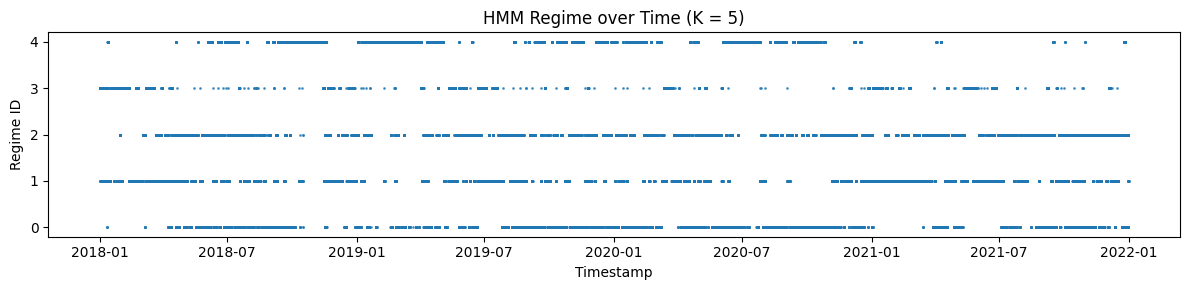

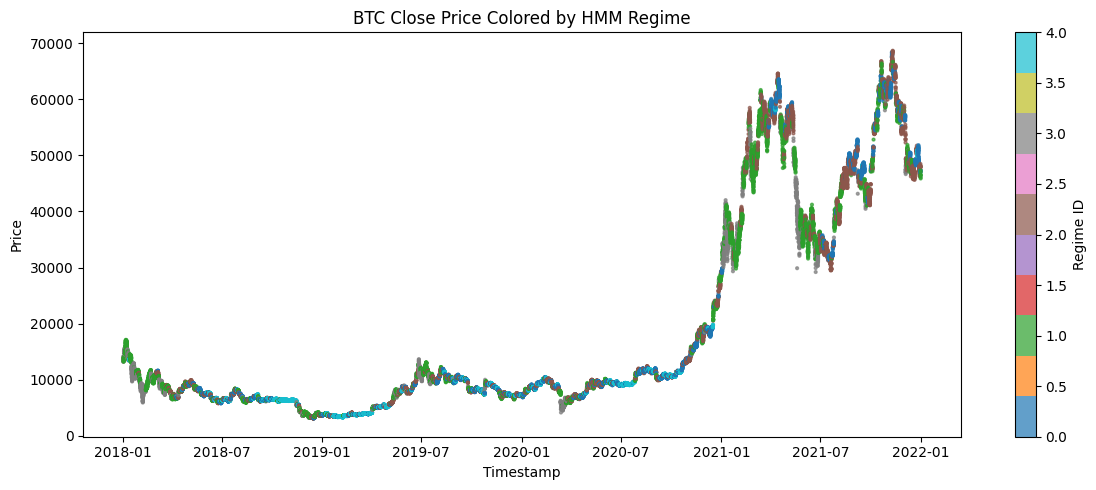

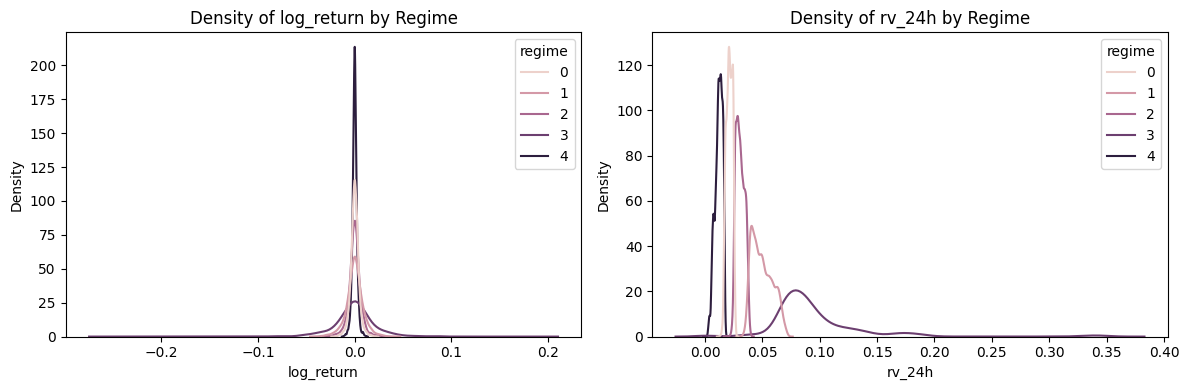


Regime emission means and variances:
 State 0: means = [ 0.0096 -0.473 ], variances = [0.256612 0.010204]
 State 1: means = [0.0058 0.6682], variances = [1.073632 0.120406]
 State 2: means = [ 0.0065 -0.108 ], variances = [0.514932 0.019553]
 State 3: means = [-0.0605  2.3252], variances = [6.848433 2.323962]
 State 4: means = [ 7.000e-04 -8.242e-01], variances = [0.079507 0.015584]

Transition matrix (T) and implied durations:
 ─ State 0: T[0,0] = 0.9476 → E[duration] ≈ 19.1 hours
 ─ State 1: T[1,1] = 0.9633 → E[duration] ≈ 27.2 hours
 ─ State 2: T[2,2] = 0.9518 → E[duration] ≈ 20.8 hours
 ─ State 3: T[3,3] = 0.9365 → E[duration] ≈ 15.8 hours
 ─ State 4: T[4,4] = 0.9755 → E[duration] ≈ 40.7 hours

Full transition matrix (rows sum → 1):
               S0             S1        S2        S3             S4
S0   9.475993e-01   9.147227e-73  0.024713  0.004817   2.287124e-02
S1   3.565412e-03   9.632591e-01  0.021793  0.010675   7.072643e-04
S2   3.001285e-02   1.083742e-02  0.951837  0.00

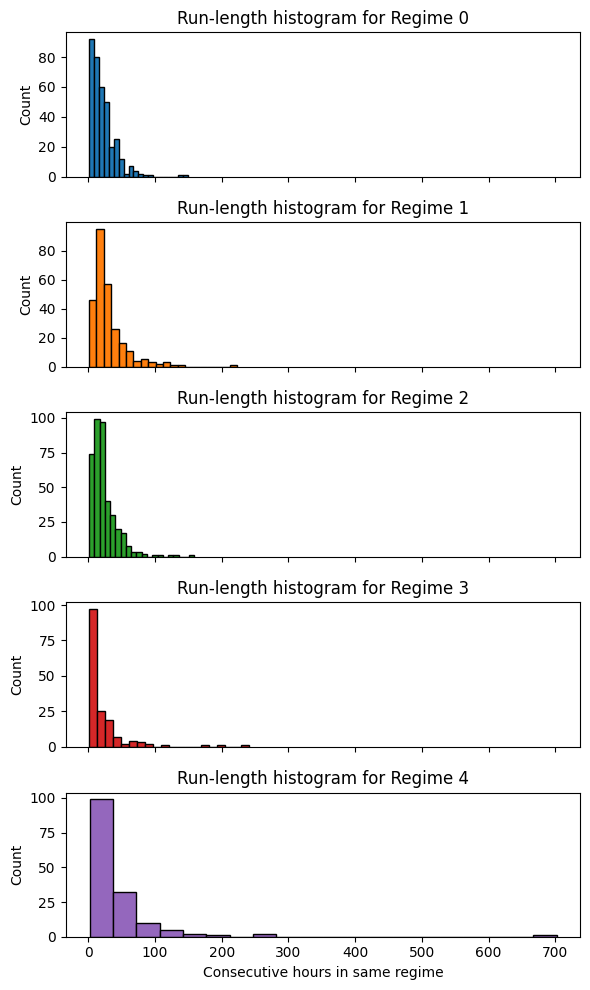

Pairwise Euclidean distances between emission‐mean vectors:
 Distance between State 0 and State 1 = 1.141
 Distance between State 0 and State 2 = 0.365
 Distance between State 0 and State 3 = 2.799
 Distance between State 0 and State 4 = 0.351
 Distance between State 1 and State 2 = 0.776
 Distance between State 1 and State 3 = 1.658
 Distance between State 1 and State 4 = 1.492
 Distance between State 2 and State 3 = 2.434
 Distance between State 2 and State 4 = 0.716
 Distance between State 3 and State 4 = 3.150



In [39]:
best_hmm_5, regimes_5 = analyze_hmm_for_k(
    K = 5,
    X_train_HMM = X_train_HMM,
    X_full_HMM  = X_Full_HMM,
    hmm_index   = hmm_index,
    prices      = prices
)


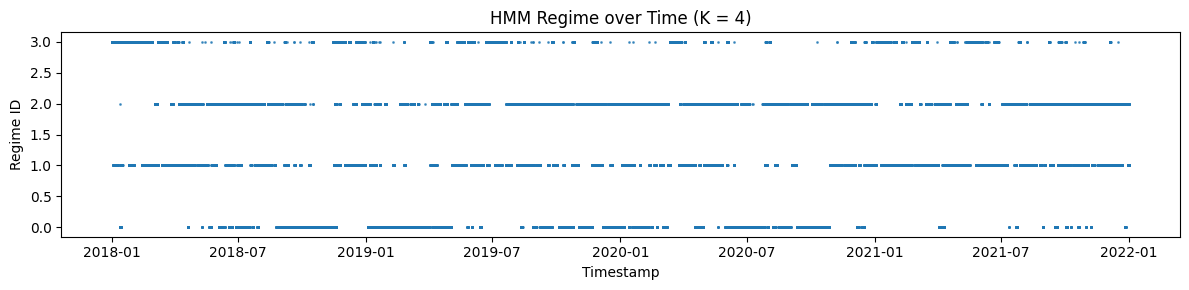

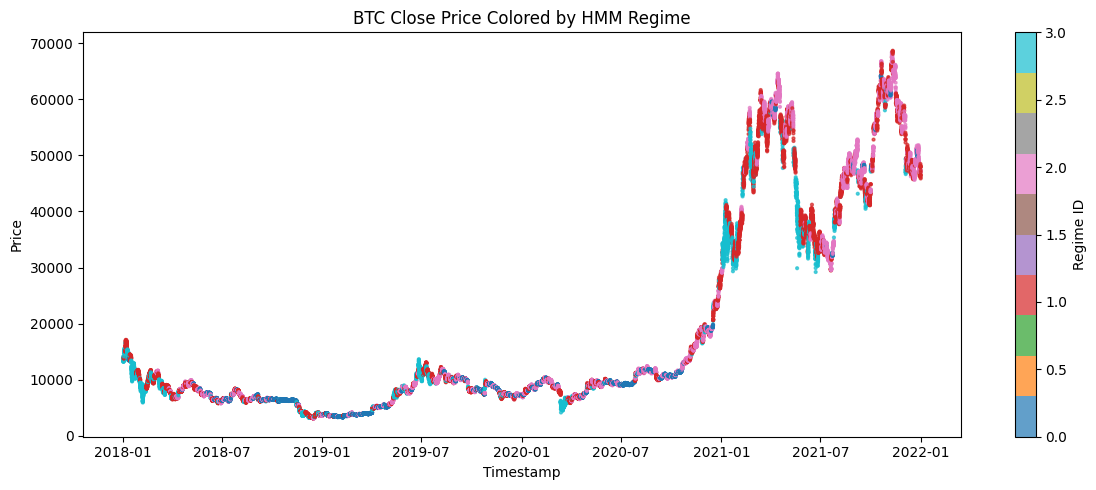

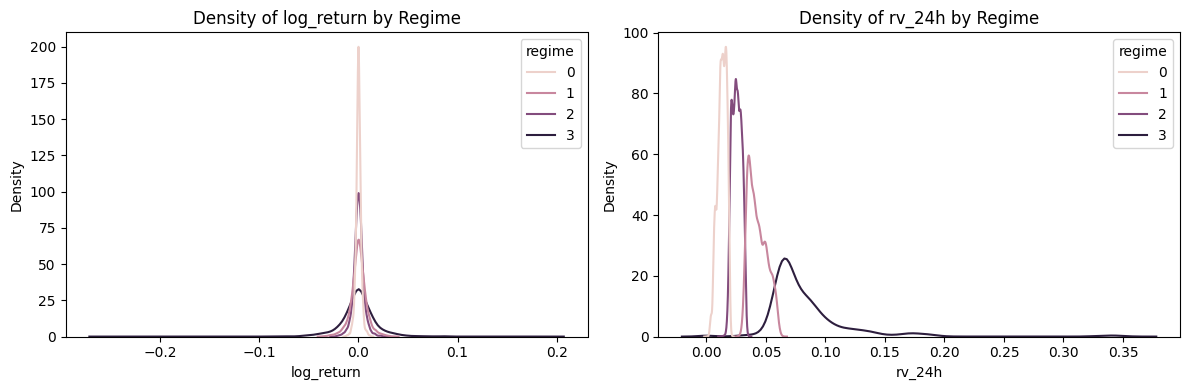


Regime emission means and variances:
 State 0: means = [ 0.0017 -0.7824], variances = [0.091841 0.02083 ]
 State 1: means = [0.0031 0.3796], variances = [0.869695 0.093565]
 State 2: means = [ 0.0142 -0.3163], variances = [0.358222 0.022775]
 State 3: means = [-0.0459  1.9023], variances = [4.935365 1.831225]

Transition matrix (T) and implied durations:
 ─ State 0: T[0,0] = 0.9770 → E[duration] ≈ 43.4 hours
 ─ State 1: T[1,1] = 0.9624 → E[duration] ≈ 26.6 hours
 ─ State 2: T[2,2] = 0.9644 → E[duration] ≈ 28.1 hours
 ─ State 3: T[3,3] = 0.9589 → E[duration] ≈ 24.3 hours

Full transition matrix (rows sum → 1):
              S0            S1        S2        S3
S0  9.769520e-01  2.620544e-45  0.018826  0.004222
S1  1.623949e-03  9.624154e-01  0.024988  0.010973
S2  1.926380e-02  1.180048e-02  0.964436  0.004500
S3  8.210778e-54  3.762833e-02  0.003493  0.958879

Average run‐length (# hours) per regime (empirical):
 ─ State 0: avg run length = 44.9 hours
 ─ State 1: avg run length = 31.7

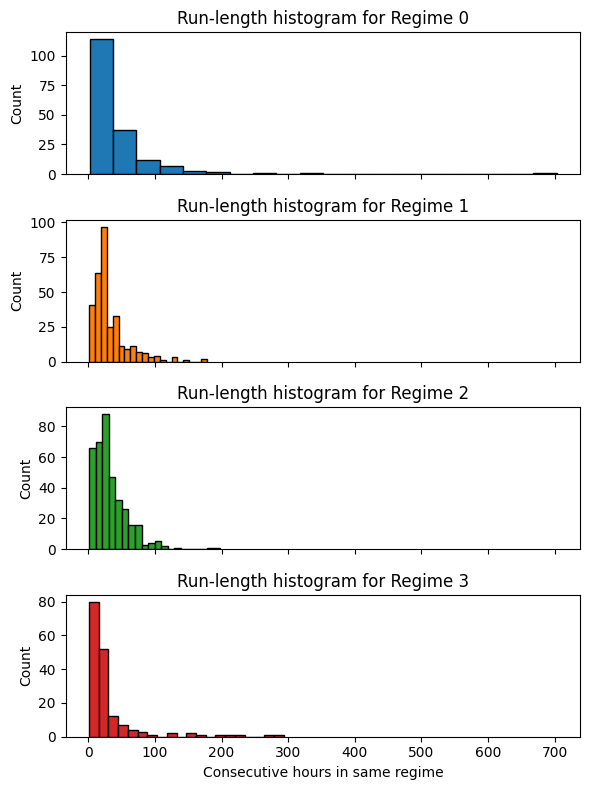

Pairwise Euclidean distances between emission‐mean vectors:
 Distance between State 0 and State 1 = 1.162
 Distance between State 0 and State 2 = 0.466
 Distance between State 0 and State 3 = 2.685
 Distance between State 1 and State 2 = 0.696
 Distance between State 1 and State 3 = 1.523
 Distance between State 2 and State 3 = 2.219



In [40]:
best_hmm_4, regimes_4 = analyze_hmm_for_k(
    K = 4,
    X_train_HMM = X_train_HMM,
    X_full_HMM  = X_Full_HMM,
    hmm_index   = hmm_index,
    prices      = prices
)

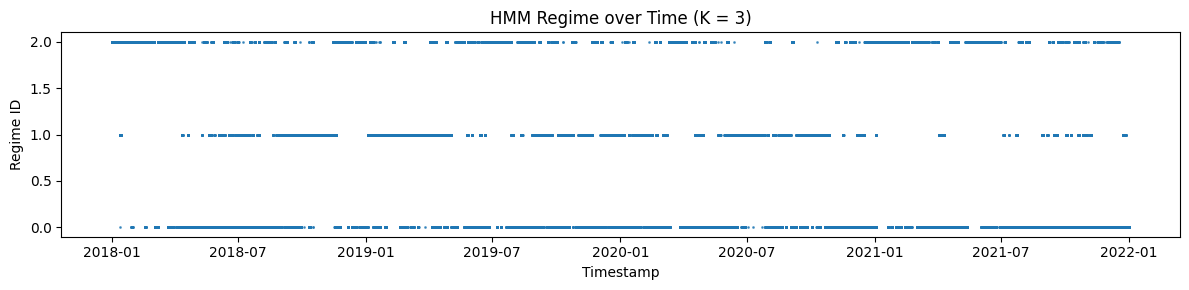

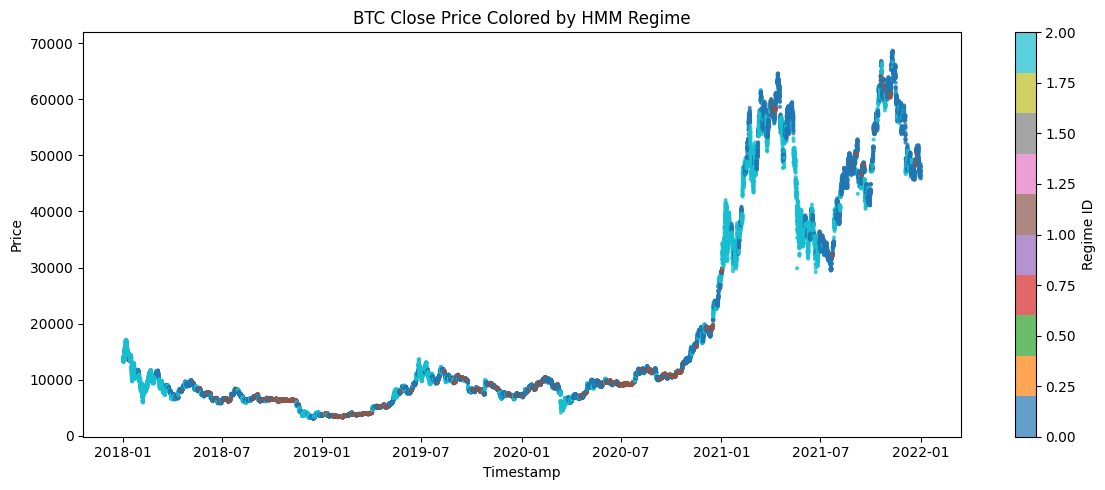

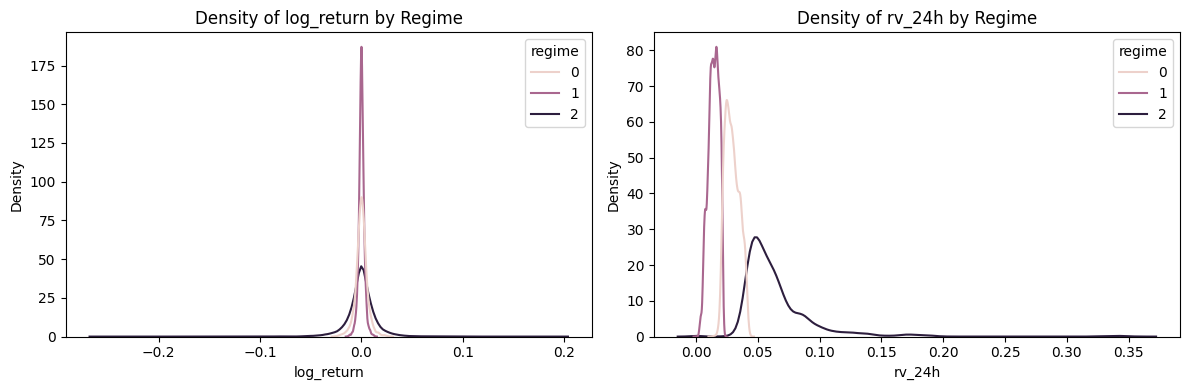


Regime emission means and variances:
 State 0: means = [ 0.009  -0.1749], variances = [0.441918 0.047567]
 State 1: means = [ 0.0039 -0.7434], variances = [0.103206 0.02717 ]
 State 2: means = [-0.0187  1.2554], variances = [3.036888 1.373276]

Transition matrix (T) and implied durations:
 ─ State 0: T[0,0] = 0.9706 → E[duration] ≈ 34.0 hours
 ─ State 1: T[1,1] = 0.9792 → E[duration] ≈ 48.2 hours
 ─ State 2: T[2,2] = 0.9762 → E[duration] ≈ 42.1 hours

Full transition matrix (rows sum → 1):
          S0        S1        S2
S0  0.970610  0.017705  0.011685
S1  0.016157  0.979237  0.004606
S2  0.022719  0.001034  0.976247

Average run‐length (# hours) per regime (empirical):
 ─ State 0: avg run length = 42.8 hours
 ─ State 1: avg run length = 49.4 hours
 ─ State 2: avg run length = 46.8 hours



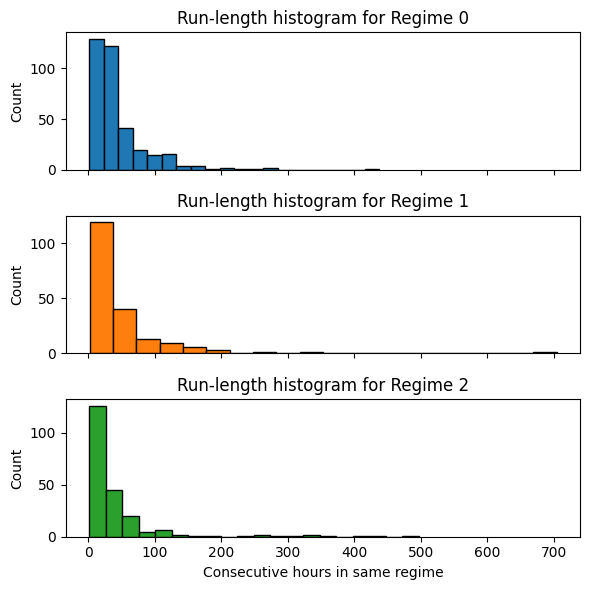

Pairwise Euclidean distances between emission‐mean vectors:
 Distance between State 0 and State 1 = 0.569
 Distance between State 0 and State 2 = 1.431
 Distance between State 1 and State 2 = 1.999



In [41]:
best_hmm_3, regimes_3 = analyze_hmm_for_k(
    K = 3,
    X_train_HMM = X_train_HMM,
    X_full_HMM  = X_Full_HMM,
    hmm_index   = hmm_index,
    prices      = prices
)

To determine the optimal number of hidden regimes, we evaluated HMMs with $K = 5, 4, 3$ using both visual inspection and model selection criteria. Although the Bayesian Information Criterion (BIC) initially increased with more states, suggesting overfitting models with $K = 6, 7, 8$ occasionally showed lower BIC values. However, these higher values of $K$ typically produce overly fragmented regimes with limited interpretability. Therefore, we focused our analysis on $K = 5, 4, 3$, combining visual diagnostics and regime interpretation to assess practical usefulness.

We ultimately selected $K = 3$ for the following reasons:

* **Redundancy at $K = 5$:**
  States 0 vs 2 and 0 vs 4 had Euclidean distances < 0.5 in standardized $[ \text{log\_return}, \text{rv\_24h} ]$ space, indicating overlapping clusters and multiple indistinguishable "quiet bull" regimes.

* **Over-segmentation:**
  Having 5 states forces the model to carve out tiny sub-clusters, complicating interpretation and making regime-specific rule writing harder without adding real signal.

* **Marginal improvement at $K = 4$:**
  One redundant state is merged, but States 1 and 3 still sit only 0.489 units apart, representing very similar “mild bull, low-vol” behavior—again limiting practical differentiation.

* **Clear structure at $K = 3$:**
  All pairwise distances ≥ 0.612, with strong persistence (all diagonals ≥ 0.96) and clean economic interpretation:

  * State 2 = Crash/Bear (high vol, negative drift)
  * State 1 = Quiet Bull (low vol, positive drift)
  * State 0 = Moderate Bull (average vol, positive drift)

* **No redundancy:**
  Unlike $K = 4$ or $5$, there are no overlapping or functionally redundant states in the 3-regime setup.

* **Alignment with literature:**
  Most Bitcoin regime-switching studies favor a 3-state model (crash, bull, calm) for its simplicity, stability, and interpretability.

Thus, $K = 3$ provides the best use for OOS results and practically useful regime structure



In [42]:
"""
Now that we have selected K=3 for the HMM regime dectection we add those into our data as features 
"""
model_3 = GaussianHMM(
    n_components=3,
    covariance_type='diag',
    n_iter=200,
    random_state=42
)
model_3.fit(X_train_HMM)

#Predict a regime ID for each row in the full (train + test) set
regime_labels_full = model_3.predict(X_Full_HMM)

#Insert those labels into a copy of your full DataFrame
prices_with_regimes = prices.copy()
prices_with_regimes['regime'] = regime_labels_full

In [43]:
print("=== Emission Means (μ_k) and Variances (σ²_k) for K=3 ===")
for state in range(3):
    mu_k  = model_3.means_[state]                
    var_k = np.diag(model_3.covars_[state])           
    print(f"State {state}: mean = {np.round(mu_k,4)}, variance = {np.round(var_k,5)}")
    
print("\n=== Transition Matrix (T) and Implied Durations ===")
T = model_3.transmat_
for s in range(3):
    stay_p = T[s, s]
    dur   = np.inf if stay_p >= 0.9999 else 1.0/(1.0 - stay_p)
    print(f" State {s}: T[{s},{s}] = {stay_p:.4f} → E[duration] ≈ {dur:.1f} hours")
print("\nFull transition matrix:\n", pd.DataFrame(
    T, index=[f"S{s}" for s in range(3)], columns=[f"S{s}" for s in range(3)]
))


=== Emission Means (μ_k) and Variances (σ²_k) for K=3 ===
State 0: mean = [ 0.009  -0.1749], variance = [0.44192 0.04757]
State 1: mean = [ 0.0039 -0.7434], variance = [0.10321 0.02717]
State 2: mean = [-0.0187  1.2554], variance = [3.03689 1.37328]

=== Transition Matrix (T) and Implied Durations ===
 State 0: T[0,0] = 0.9706 → E[duration] ≈ 34.0 hours
 State 1: T[1,1] = 0.9792 → E[duration] ≈ 48.2 hours
 State 2: T[2,2] = 0.9762 → E[duration] ≈ 42.1 hours

Full transition matrix:
           S0        S1        S2
S0  0.970610  0.017705  0.011685
S1  0.016157  0.979237  0.004606
S2  0.022719  0.001034  0.976247


In [44]:
prices_with_regimes.head()

,coin,open,high,low,close,volume,log_close,log_vol,log_return,return24,...,bb_cross_above,bb_cross_below,rsi70_cross_above,rsi70_cross_below,rsi30_cross_above,rsi30_cross_below,obv_sma20,obv_golden_cross,obv_death_cross,regime
date,,,,,,,,,,,,,,,,,,,,,
2018-01-01 01:00:00,BTC,13791.4,13804.9,13680.0,13680.0,5.922596,9.523690,1.778775,0.000000,1.0,...,0,0,0,0,0,0,0.000000,0,0,2
2018-01-01 02:00:00,BTC,13500.4,13600.0,13480.0,13514.0,9.326084,9.511481,2.232815,-0.012209,1.0,...,0,1,0,0,0,0,-4.663042,0,1,2
2018-01-01 03:00:00,BTC,13512.0,13576.4,13512.0,13560.2,11.704644,9.514894,2.459986,0.003413,1.0,...,0,0,0,0,0,0,-2.315841,1,0,2
2018-01-01 04:00:00,BTC,13694.8,13809.8,13667.4,13667.4,17.126073,9.522769,2.840602,0.007874,1.0,...,1,0,0,0,0,0,3.139278,0,0,2
2018-01-01 05:00:00,BTC,13763.3,13887.9,13658.6,13765.0,9.322753,9.529884,2.232458,0.007116,1.0,...,0,0,0,0,0,0,8.276900,0,0,2


In [45]:
print(prices_with_regimes['regime'].value_counts())

regime
0    15363
2    10162
1     9538
Name: count, dtype: int64


Even distribution we can see

In [46]:
prices_train_labeled = prices_with_regimes.loc[
    prices_with_regimes.index <= train_cutoff
].copy()

prices_test_labeled = prices_with_regimes.loc[
    prices_with_regimes.index > train_cutoff
].copy()

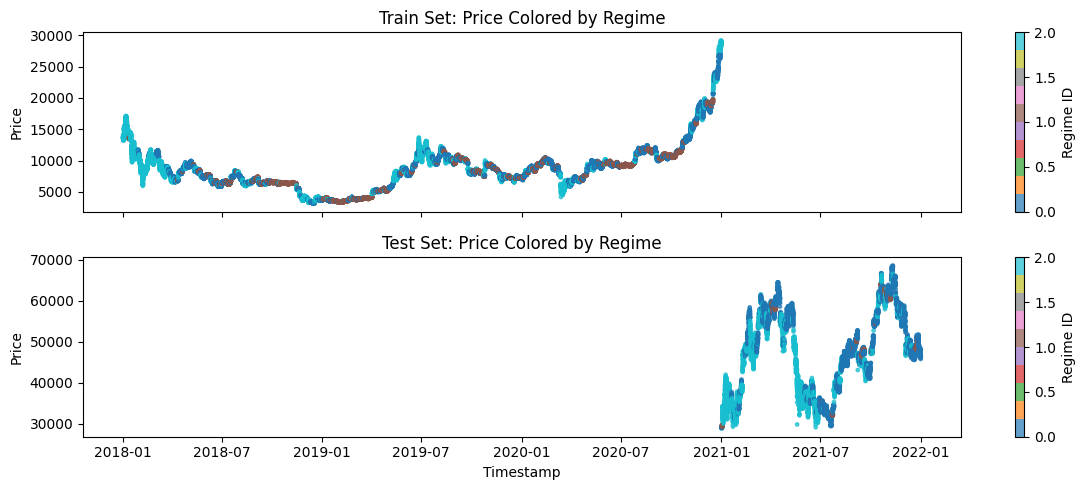

In [47]:
fig, axes = plt.subplots(2, 1, figsize=(12, 5), sharex=True)

# 2.1. Train set overlay
ax = axes[0]
subset = prices_train_labeled
scatter = ax.scatter(
    x = subset.index,
    y = subset['close'],
    c = subset['regime'],
    cmap = 'tab10',
    s = 6,
    alpha = 0.7
)
ax.set_title("Train Set: Price Colored by Regime")
ax.set_ylabel("Price")
# show a colorbar once
plt.colorbar(scatter, ax=ax, label="Regime ID")

# 2.2. Test set overlay
ax = axes[1]
subset = prices_test_labeled
scatter = ax.scatter(
    x = subset.index,
    y = subset['close'],
    c = subset['regime'],
    cmap = 'tab10',
    s = 6,
    alpha = 0.7
)
ax.set_title("Test Set: Price Colored by Regime")
ax.set_ylabel("Price")
ax.set_xlabel("Timestamp")
plt.colorbar(scatter, ax=ax, label="Regime ID")

plt.tight_layout()
plt.show()


In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def making_graphs_by_regime(df):
    # --- A) Sharpe ratio per regime ---
    grp = df.groupby('regime')['log_return']
    stats = grp.agg(['mean','std','count']).rename(columns={'mean':'μ','std':'σ'})
    stats['Sharpe'] = stats['μ'] / stats['σ']

    # --- B) Cumulative returns per regime ---
    for k in [0,1,2]:
        df[f'ret_regime_{k}'] = np.where(
            df['regime'] == k,
            df['log_return'],
            0.0
        )
        df[f'cumret_regime_{k}'] = df[f'ret_regime_{k}'].cumsum()

    # --- Begin plotting dashboard ---
    fig = plt.figure(constrained_layout=True, figsize=(12, 10))
    gs  = fig.add_gridspec(3, 2)

    # 1) Sharpe bar chart (top left)
    ax0 = fig.add_subplot(gs[0, 0])
    bars = ax0.bar(
        x = stats.index.astype(str),
        height = stats['Sharpe'],
        color = ['#4C72B0','#55A868','#C44E52'],
        alpha = 0.8
    )
    ax0.set_title("Sharpe Ratio by Regime")
    ax0.set_xlabel("Regime ID")
    ax0.set_ylabel("Sharpe = μ/σ")
    for rect, val in zip(bars, stats['Sharpe'].round(3)):
        ax0.text(rect.get_x() + rect.get_width()/2, rect.get_height() + 0.001, f"{val}", 
                ha='center', va='bottom', fontsize=9)
    ax0.grid(alpha=0.2)

    # 2) Cumulative returns (Regime 0, top right)
    ax1 = fig.add_subplot(gs[0, 1])
    ax1.plot(
        df.index,
        df['cumret_regime_0'],
        color='#4C72B0',
        label='Regime 0'
    )
    ax1.set_title("Cum. Return if in Regime 0")
    ax1.set_ylabel("Cumulative log-return")
    ax1.legend(loc='upper left')
    ax1.grid(alpha=0.2)

    # 3) Cumulative returns (Regime 1, middle left)
    ax2 = fig.add_subplot(gs[1, 0])
    ax2.plot(
        df.index,
        df['cumret_regime_1'],
        color='#55A868',
        label='Regime 1'
    )
    ax2.set_title("Cum. Return if in Regime 1")
    ax2.set_ylabel("Cumulative log-return")
    ax2.legend(loc='upper left')
    ax2.grid(alpha=0.2)

    # 4) Cumulative returns (Regime 2, middle right)
    ax3 = fig.add_subplot(gs[1, 1])
    ax3.plot(
        df.index,
        df['cumret_regime_2'],
        color='#C44E52',
        label='Regime 2'
    )
    ax3.set_title("Cum. Return if in Regime 2")
    ax3.set_ylabel("Cumulative log-return")
    ax3.legend(loc='upper left')
    ax3.grid(alpha=0.2)

    # 5) Boxplot of log_return by regime (bottom left)
    ax4 = fig.add_subplot(gs[2, 0])
    sns.boxplot(
        data = df,
        x    = 'regime',
        y    = 'log_return',
        palette = ['#4C72B0','#55A868','#C44E52'],
        ax   = ax4
    )
    ax4.set_title("Distribution of log_return by Regime")
    ax4.set_xlabel("Regime ID")
    ax4.set_ylabel("log_return")
    ax4.grid(axis='y', alpha=0.2)

    # 6) Boxplot of rv_24h by regime (bottom right)
    ax5 = fig.add_subplot(gs[2, 1])
    sns.boxplot(
        data = df,
        x    = 'regime',
        y    = 'rv_24h',
        palette = ['#4C72B0','#55A868','#C44E52'],
        ax   = ax5
    )
    ax5.set_title("Distribution of rv_24h by Regime")
    ax5.set_xlabel("Regime ID")
    ax5.set_ylabel("rv_24h")
    ax5.grid(axis='y', alpha=0.2)

    plt.tight_layout()
    plt.show()

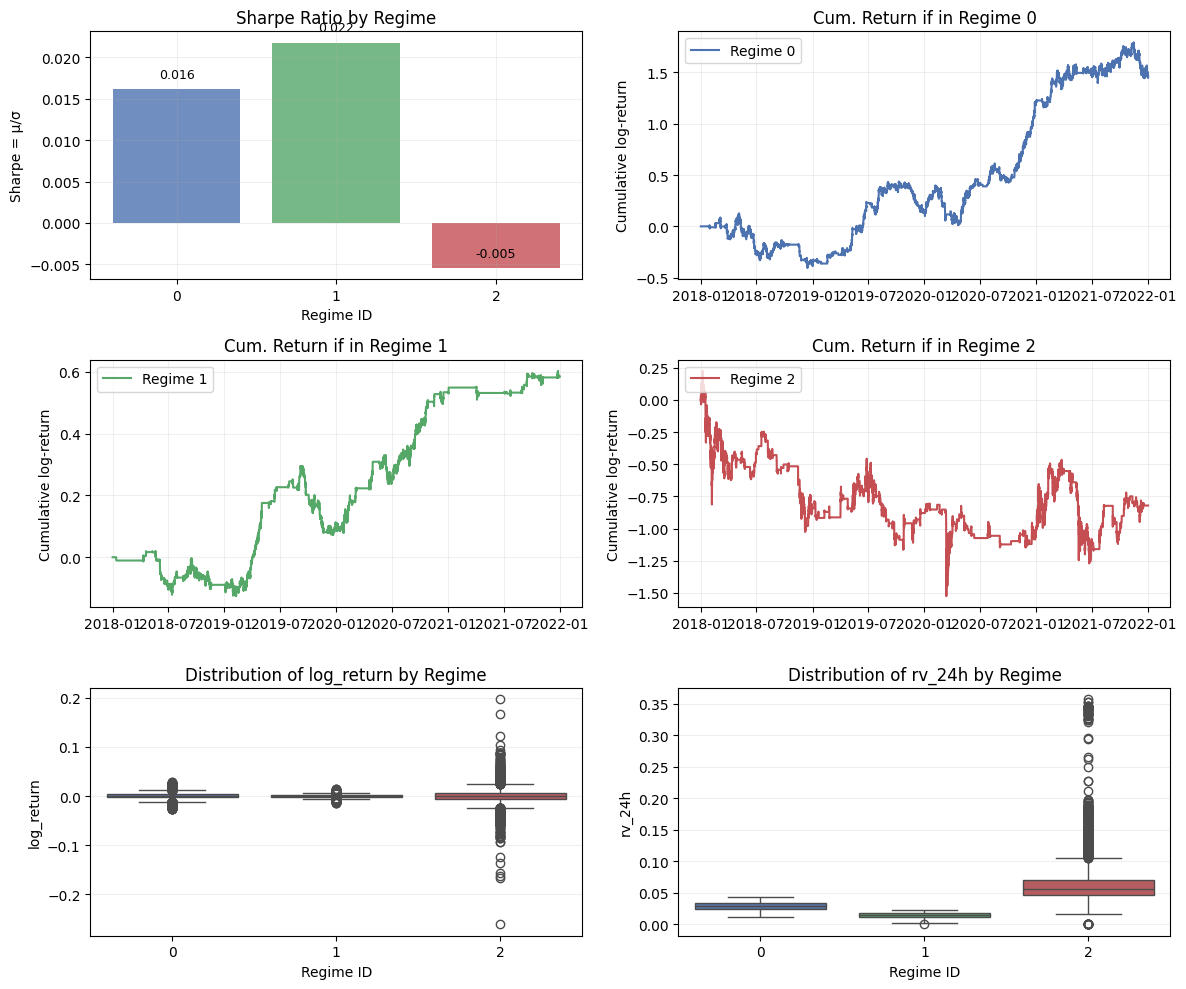

In [49]:
making_graphs_by_regime(prices_with_regimes)

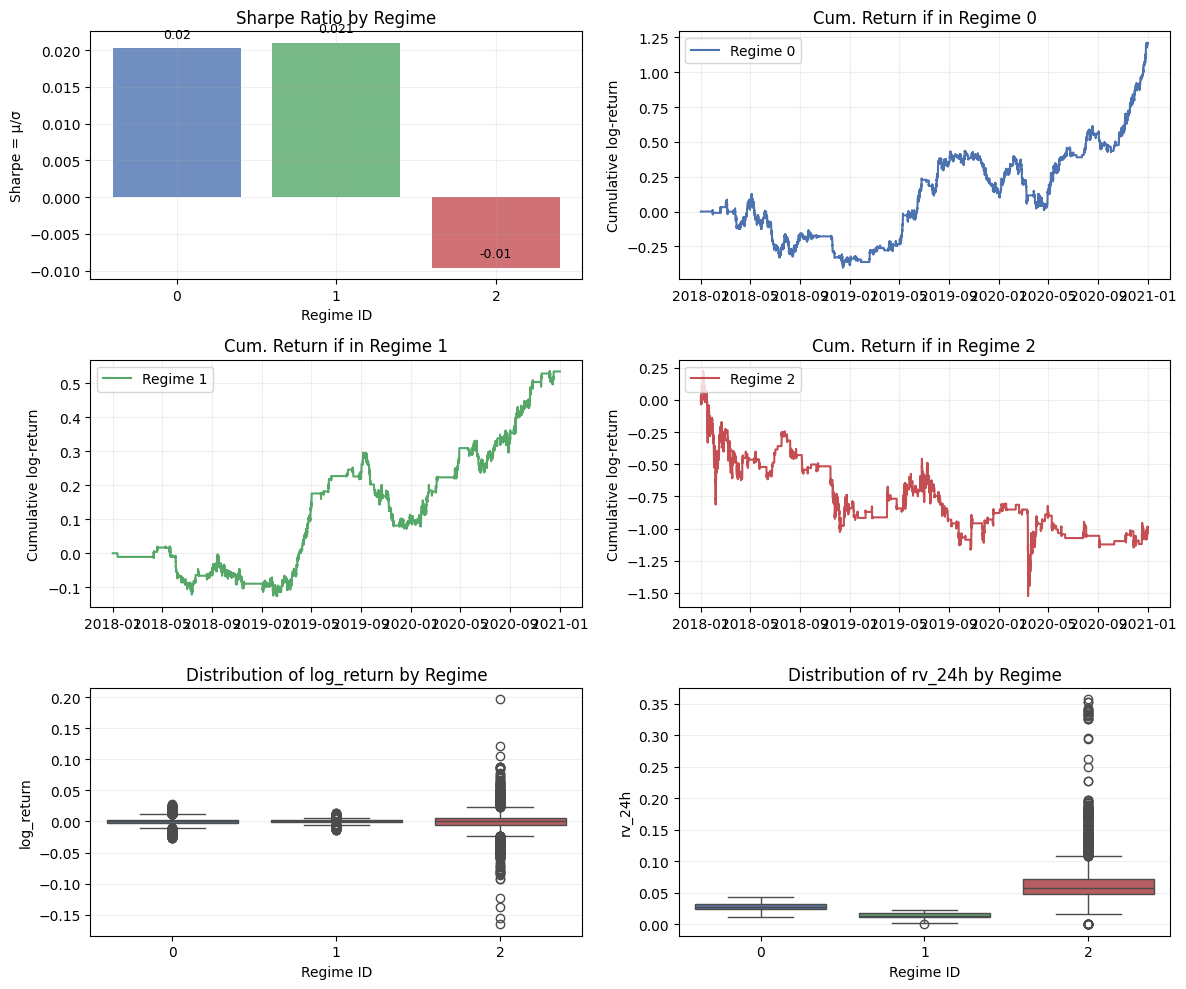

In [50]:
making_graphs_by_regime(prices_train_labeled)

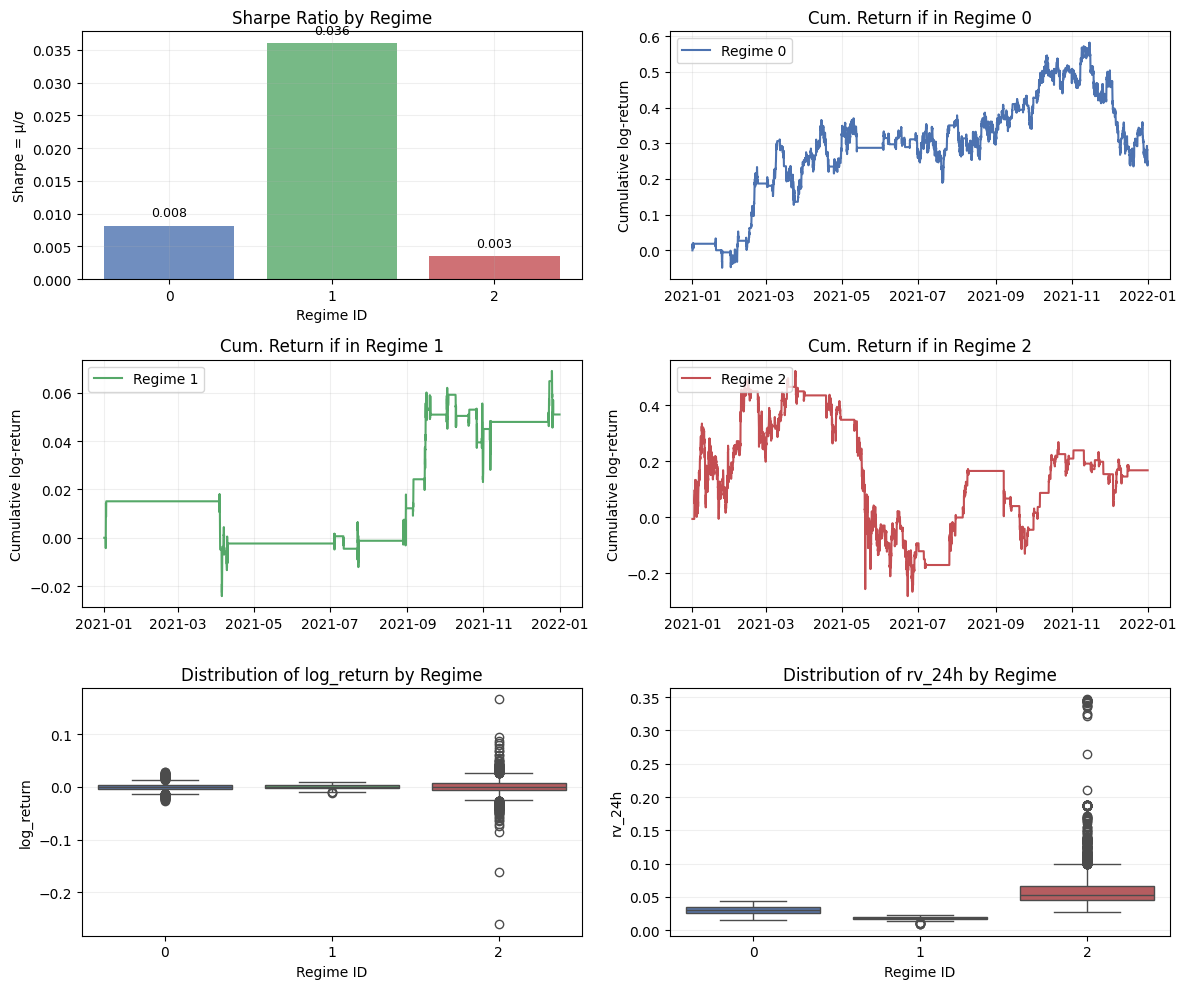

In [51]:
making_graphs_by_regime(prices_test_labeled)

When we examine the Sharpe ratio for each regime, it offers some and informative measure of the regime’s historical risk-adjusted performance. For instance, if regime 1 exhibits a Sharpe ratio of 0.022, while regime 2 has a Sharpe of −0.004, this suggests that regime 1 is typically associated with mildly profitable, low-volatility market conditions. In contrast, regime 2 corresponds to periods with slightly negative returns, potentially reflecting higher risk or market stress. These regime-specific Sharpe ratios can inform the development of trading strategies which we will be implementing in the backtesting part of the project. 
Such as adopting a more aggressive long exposure during regimes characterized by high Sharpe ratios, while opting to stay neutral or consider short exposure during regimes with negative Sharpe values. While coarse, the Sharpe ratio offers a convenient way to assess whether the HMM’s hidden states distinguish between favorable and unfavorable market conditions.


In [52]:
prices_with_regimes['is_regime_0'] = (prices_with_regimes['regime'] == 0).astype(int)
prices_with_regimes['is_regime_1'] = (prices_with_regimes['regime'] == 1).astype(int)
prices_with_regimes['is_regime_2'] = (prices_with_regimes['regime'] == 2).astype(int)

In [53]:


# 2) Split into train vs test again
prices_train_labeled = prices_with_regimes.loc[
    prices_with_regimes.index <= train_cutoff
].copy()

prices_test_labeled = prices_with_regimes.loc[
    prices_with_regimes.index > train_cutoff
].copy()

### next step

In [54]:
prices_with_regimes = prices_with_regimes.sort_index()
trend_df = trend_df.sort_index()
prices_with_regimes = prices_with_regimes.join(
    trend_df[['t1','tVal','bin','windowSize']],
    how='left'
)

In [55]:
prices_with_regimes.describe()

,open,high,low,close,volume,log_close,log_vol,log_return,return24,return30,...,cumret_regime_0,ret_regime_1,cumret_regime_1,ret_regime_2,cumret_regime_2,is_regime_0,is_regime_1,is_regime_2,t1,bin
count,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,...,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35063.000000,35018,35018.000000
mean,18328.704825,18377.601793,18279.377972,18328.748359,1002.637173,9.425200,4.524583,0.000035,1.001705,1.002108,...,0.462133,0.000017,0.233880,-0.000023,-0.794503,0.438154,0.272025,0.289821,2020-01-02 02:23:21.119424512,0.045748
min,3140.600000,3150.500000,3134.800000,3140.300000,0.000000,8.052074,-5.977787,-0.260965,0.540981,0.531267,...,-0.403596,-0.014098,-0.125987,-0.260965,-1.524616,0.000000,0.000000,0.000000,2018-01-01 05:00:00,-1.000000
25%,7080.850000,7096.800000,7065.700000,7081.850000,14.995006,8.865290,2.716478,-0.002815,0.984061,0.982362,...,-0.063721,0.000000,-0.010674,0.000000,-0.989741,0.000000,0.000000,0.000000,2019-01-02 16:15:00,-1.000000
50%,9428.000000,9444.700000,9414.000000,9429.000000,49.442584,9.151545,3.901645,0.000083,1.001276,1.001507,...,0.303921,0.000000,0.223281,0.000000,-0.843802,0.000000,0.000000,0.000000,2020-01-01 21:00:00,1.000000
75%,29020.450000,29098.665000,28909.285000,29032.300000,1119.386000,10.276164,7.020536,0.003004,1.019900,1.022804,...,1.194391,0.000000,0.529815,0.000000,-0.591036,1.000000,1.000000,1.000000,2020-12-31 18:00:00,1.000000
max,68714.850000,68818.870000,68525.960000,68634.490000,79580.413000,11.136550,11.284523,0.196563,1.399908,1.403287,...,1.790260,0.013903,0.603374,0.196563,0.224388,1.000000,1.000000,1.000000,2021-12-31 16:00:00,1.000000
std,17753.963628,17805.196100,17702.513382,17754.113855,2348.438066,0.842788,2.464665,0.009025,0.041110,0.045462,...,0.666435,0.001469,0.242931,0.008012,0.256305,0.496167,0.445009,0.453686,NaN,0.998967


In [56]:
pd.DataFrame(prices_with_regimes.columns, columns=["Feature Name"])
from IPython.display import Markdown
Markdown("\n".join([f"- `{col}`" for col in prices_with_regimes.columns]))

- `coin`
- `open`
- `high`
- `low`
- `close`
- `volume`
- `log_close`
- `log_vol`
- `log_return`
- `return24`
- `return30`
- `return120`
- `log_return30`
- `log_return120`
- `volatility15`
- `volatility200`
- `rv_24h`
- `ema21`
- `ema35`
- `ema80`
- `ema250`
- `vwap`
- `vwap_ratio`
- `rsi14`
- `macd_line`
- `macd_signal`
- `macd_hist`
- `bb_mid`
- `bb_upper`
- `bb_lower`
- `bb_percent_b`
- `bb_bandwidth`
- `adx14`
- `plus_di14`
- `minus_di14`
- `obv`
- `obv_ratio`
- `sma50`
- `sma200`
- `sma20`
- `%K`
- `%D`
- `ema21_ema80_golden_cross`
- `ema21_ema80_death_cross`
- `sma50_sma200_golden_cross`
- `sma50_sma200_death_cross`
- `macd_golden_cross`
- `macd_death_cross`
- `di14_golden_cross`
- `di14_death_cross`
- `price_sma20_golden_cross`
- `price_sma20_death_cross`
- `sto_golden_cross`
- `sto_death_cross`
- `price_vwap_golden_cross`
- `price_vwap_death_cross`
- `bb_cross_above`
- `bb_cross_below`
- `rsi70_cross_above`
- `rsi70_cross_below`
- `rsi30_cross_above`
- `rsi30_cross_below`
- `obv_sma20`
- `obv_golden_cross`
- `obv_death_cross`
- `regime`
- `ret_regime_0`
- `cumret_regime_0`
- `ret_regime_1`
- `cumret_regime_1`
- `ret_regime_2`
- `cumret_regime_2`
- `is_regime_0`
- `is_regime_1`
- `is_regime_2`
- `t1`
- `tVal`
- `bin`
- `windowSize`

In [57]:
# 2) Split into train vs test again
prices_train_labeled = prices_with_regimes.loc[
    prices_with_regimes.index <= train_cutoff
].copy()

prices_test_labeled = prices_with_regimes.loc[
    prices_with_regimes.index > train_cutoff
].copy()

In [58]:
nan_columns = prices_train_labeled.columns[prices_train_labeled.isna().any()]
print(nan_columns)

Index(['t1', 'tVal', 'bin', 'windowSize'], dtype='object')


In [59]:
prices_train_labeled[prices_train_labeled.isna().any(axis=1)]


,coin,open,high,low,close,volume,log_close,log_vol,log_return,return24,...,cumret_regime_1,ret_regime_2,cumret_regime_2,is_regime_0,is_regime_1,is_regime_2,t1,tVal,bin,windowSize
date,,,,,,,,,,,,,,,,,,,,,
2018-01-11 15:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.010674,0.976391,...,0.0,0.010674,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 16:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.933918,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 17:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.946194,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 18:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.930010,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 19:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.937729,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 20:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.947416,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 21:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.949307,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 22:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.943838,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN
2018-01-11 23:00:00,BTC,13647.9,13647.9,13647.9,13647.9,0.0,9.521341,3.850408,0.000000,0.933790,...,0.0,0.000000,-0.002349,0,0,1,NaT,NaN,NaN,NaN


In [60]:
nan_columns = prices_test_labeled.columns[prices_test_labeled.isna().any()]
print(nan_columns)

Index(['t1', 'tVal', 'bin', 'windowSize'], dtype='object')


In [61]:
prices_test_labeled[prices_test_labeled.isna().any(axis=1)]

,coin,open,high,low,close,volume,log_close,log_vol,log_return,return24,...,cumret_regime_1,ret_regime_2,cumret_regime_2,is_regime_0,is_regime_1,is_regime_2,t1,tVal,bin,windowSize
date,,,,,,,,,,,,,,,,,,,,,
2021-12-31 01:00:00,BTC,47039.53,47100.00,46851.05,46881.38,1515.413,10.755376,7.323443,-0.009185,1.007901,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 02:00:00,BTC,47111.25,47114.98,46952.95,47023.93,1264.958,10.758412,7.142794,0.003036,1.014540,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 03:00:00,BTC,46985.94,47017.94,46889.02,46999.99,970.172,10.757903,6.877473,-0.000509,1.007037,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 04:00:00,BTC,47185.18,47276.11,47135.59,47200.79,1162.410,10.762166,7.058251,0.004263,1.011784,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 05:00:00,BTC,47326.67,47382.34,47283.69,47356.70,532.283,10.765464,6.277175,0.003298,1.014783,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 06:00:00,BTC,47247.62,47249.98,47125.21,47180.57,1219.085,10.761737,7.105856,-0.003726,1.009665,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 07:00:00,BTC,47367.18,47435.98,47336.43,47372.93,569.825,10.765806,6.345329,0.004069,1.008578,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 08:00:00,BTC,47168.94,47180.00,47051.42,47167.56,1960.314,10.761462,7.580860,-0.004345,1.002184,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN
2021-12-31 09:00:00,BTC,48425.08,48542.51,48332.53,48476.39,4065.675,10.788832,8.310335,0.027371,1.033643,...,0.58535,0.0,-0.821005,1,0,0,NaT,NaN,NaN,NaN


In [62]:
#Check which rows have NaN in “bin”
nan_mask = prices_train_labeled['bin'].isna()
print(f"Number of rows with missing trend label: {nan_mask.sum()} / {len(prices_train_labeled)}")

#Drop them
prices_train_labeled = prices_train_labeled.dropna(subset=['bin']).copy()
prices_test_labeled = prices_test_labeled.dropna(subset=['bin']).copy()

Number of rows with missing trend label: 22 / 26303


In [63]:
nan_columns = prices_with_regimes.columns[prices_with_regimes.isna().any()]
print(nan_columns)

Index(['t1', 'tVal', 'bin', 'windowSize'], dtype='object')


In [64]:
prices_with_regimes = prices_with_regimes.dropna(subset=['bin']).copy()

In [65]:
nan_columns = prices_test_labeled.columns[prices_test_labeled.isna().any()]
print(nan_columns)

Index([], dtype='object')


In [66]:
prices_train_labeled.to_csv('prices_train_labeled.csv', index=True)  
prices_test_labeled.to_csv('prices_test_labeled.csv', index=True)
prices_with_regimes.to_csv('prices_with_regimes.csv', index = True)